In [1]:
import datetime, time
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import itertools

from IPython.display import clear_output, display, HTML

In [2]:
train = pd.read_csv(r"D:\Kaggle\train_preprocessed_new.csv")
test = pd.read_csv(r"D:\Kaggle\test_preprocessed_new.csv")
all_data = pd.read_csv(r"D:\Kaggle\all_data_preprocessed_new.csv")

In [3]:
train_X = train.loc[:, train.columns != 'totals.totalTransactionRevenue']
train_y = train['totals.totalTransactionRevenue']

In [4]:
test_X = test.loc[:, test.columns != 'totals.totalTransactionRevenue']
test_y = test['totals.totalTransactionRevenue']

In [5]:
all_data_X = all_data.loc[:, all_data.columns != 'totals.totalTransactionRevenue']
all_data_y = all_data['totals.totalTransactionRevenue']

In [6]:
activation_functions = [None, tf.nn.relu, tf.nn.leaky_relu, tf.nn.log_softmax]
hidden_layer_sizes = [(10,), (14, 7), (14, 7, 3)]
epochs = [2, 5, 10]
optimizers = ['adadelta', 'sgd', 'adam']

parameters = []
for e in epochs:
    for o in optimizers:
        for hidden in hidden_layer_sizes:
            for f in activation_functions:
                h = [0]*len(hidden)
                for i in range(len(hidden)):
                    h[i] = (hidden[i], f)

            parameters.append((h, e, o))
                                

print(len(parameters))
# parameters

27


In [8]:
kf = KFold(n_splits = 5, random_state = 0)
    
evaluations = []

iteration = 0
for hidden_layers, number_of_epochs, optimizer in parameters:
    evaluation = {
        'params': {'hidden_layers':hidden_layers, 'epochs': number_of_epochs, 'optimizer': optimizer},
        'fit_times': [0]*5,
        'train_scores': [0]*5,
        'test_scores': [0]*5,
        'mean_fit_time': 0,
        'std_fit_time': 0,
        'mean_train_scores': 0,
        'std_train_scores': 0,
        'mean_test_scores': 0,
        'std_test_scores': 0
    }

    fold = 0
    for train_index, test_index in kf.split(all_data_X):
        iteration = iteration + 1
        clear_output()
        print(iteration, "of", 5*len(parameters), 'Iterations')
        print("Parameters: ", (hidden_layers, number_of_epochs, optimizer), 'Fold:', fold+1)            

        X_train, X_test = all_data_X.loc[train_index], all_data_X.loc[test_index]
        y_train, y_test = all_data_y.loc[train_index], all_data_y.loc[test_index]

        model = tf.keras.models.Sequential() # Declare the model type

        model.add(tf.keras.layers.Dense(23, input_shape = (23,), activation = tf.nn.relu)) # Declare what(if any) to do in the input layer

        # Hidden Layers
        for layer in hidden_layers:
            model.add(tf.keras.layers.Dense(layer[0], activation = layer[1]))

        model.add(tf.keras.layers.Dense(1,)) # Output Layer layer

        model.compile(optimizer = optimizer,
                      loss = 'mse'
#                           metrics = ['mse', 'accuracy']
                     )
        fit_timer_start = time.time()

        model.fit(X_train, y_train, epochs = number_of_epochs)

        fit_timer_end = time.time()
        hours, rem = divmod(fit_timer_end - fit_timer_start, 3600)
        minutes, seconds = divmod(rem, 60)

        print("Time Taken: {:0>2}:{:0>2}:{:05.3f}".format(int(hours),int(minutes),seconds))
#             print(evaluation['fit_times'])
        evaluation['fit_times'][fold] = (fit_timer_end - fit_timer_start)

        predictions = model.predict([X_train])
        most_probable_values = [np.argmax(prediction) for prediction in predictions]
        evaluation['train_scores'][fold] = mean_squared_error(y_train, most_probable_values)

        predictions = model.predict([X_test])
        most_probable_values = [np.argmax(prediction) for prediction in predictions]
        evaluation['test_scores'][fold] = mean_squared_error(y_test, most_probable_values)

        total_end = time.time()
        hours, rem = divmod(total_end - fit_timer_start, 3600)
        minutes, seconds = divmod(rem, 60)

        print("Total Time Taken: {:0>2}:{:0>2}:{:05.3f}".format(int(hours),int(minutes),seconds))

        fold = fold + 1
    
    evaluation['mean_fit_time'] = np.mean(np.array(evaluation['fit_times']))
    evaluation['std_fit_time'] = np.std(np.array(evaluation['fit_times']))

    evaluation['mean_train_scores'] = np.mean(np.array(evaluation['train_scores']))
    evaluation['std_train_scores'] = np.std(np.array(evaluation['train_scores']))

    evaluation['mean_test_scores'] = np.mean(np.array(evaluation['test_scores']))
    evaluation['std_test_scores'] = np.std(np.array(evaluation['test_scores']))
    
    evaluations.append(evaluation)

#     return fold_count

135 of 135 Iterations
Parameters:  ([(14, <function log_softmax_v2 at 0x000001D5A3571400>), (7, <function log_softmax_v2 at 0x000001D5A3571400>), (3, <function log_softmax_v2 at 0x000001D5A3571400>)], 10, 'adam') Fold: 5
Train on 136000 samples
Epoch 1/10
136000/136000 [==============================] - 6s 42us/sample - loss: 385044178652911.8125
Epoch 2/10
136000/136000 [==============================] - ETA: 0s - loss: 168242815218244.8125- ETA: 0s - loss: 16185630 - 6s 41us/sample - loss: 167658827603139.9688
Epoch 3/10
136000/136000 [==============================] - 6s 42us/sample - loss: 165892151102633.90622s - loss: 19
Epoch 4/10
136000/136000 [==============================] - 6s 43us/sample - loss: 154116107372661.8125
Epoch 5/10
136000/136000 [==============================] - 6s 43us/sample - loss: 141621632766137.5312
Epoch 6/10
136000/136000 [==============================] - 6s 43us/sample - loss: 140380813906255.57815s - loss: - ETA: 4s - loss: 2835 - ETA
Epoch 7/10
136

In [9]:
mean_test_scores = [evl['mean_test_scores'] for evl in evaluations]
print(mean_test_scores)
print(min(mean_test_scores))

[1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0, 1241691511582941.0]
1241691511582941.0


In [10]:
pd.DataFrame(evaluations)[['params','mean_fit_time', 'std_fit_time', 'mean_train_scores', 'std_train_scores', 'mean_test_scores', 'std_test_scores']].T

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
params,"{'hidden_layers': [(10, <function log_softmax_...","{'hidden_layers': [(14, <function log_softmax_...","{'hidden_layers': [(14, <function log_softmax_...","{'hidden_layers': [(10, <function log_softmax_...","{'hidden_layers': [(14, <function log_softmax_...","{'hidden_layers': [(14, <function log_softmax_...","{'hidden_layers': [(10, <function log_softmax_...","{'hidden_layers': [(14, <function log_softmax_...","{'hidden_layers': [(14, <function log_softmax_...","{'hidden_layers': [(10, <function log_softmax_...",...,"{'hidden_layers': [(14, <function log_softmax_...","{'hidden_layers': [(10, <function log_softmax_...","{'hidden_layers': [(14, <function log_softmax_...","{'hidden_layers': [(14, <function log_softmax_...","{'hidden_layers': [(10, <function log_softmax_...","{'hidden_layers': [(14, <function log_softmax_...","{'hidden_layers': [(14, <function log_softmax_...","{'hidden_layers': [(10, <function log_softmax_...","{'hidden_layers': [(14, <function log_softmax_...","{'hidden_layers': [(14, <function log_softmax_..."
mean_fit_time,27.0618,26.2046,21.9544,24.2579,25.7937,32.2175,31.903,27.8747,26.07,47.0817,...,78.0683,100.808,109.457,126.45,87.7248,100.571,123.44,123.819,146.894,159.168
std_fit_time,5.8566,4.05978,1.35421,1.15352,3.41517,2.83888,2.10517,2.47821,3.00199,3.36438,...,2.27253,9.10486,5.08255,7.34559,4.85686,9.04518,6.53596,10.7996,9.37727,69.8468
mean_train_scores,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,...,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15
std_train_scores,8.77496e+13,8.77496e+13,8.77496e+13,8.77496e+13,8.77496e+13,8.77496e+13,8.77496e+13,8.77496e+13,8.77496e+13,8.77496e+13,...,8.77496e+13,8.77496e+13,8.77496e+13,8.77496e+13,8.77496e+13,8.77496e+13,8.77496e+13,8.77496e+13,8.77496e+13,8.77496e+13
mean_test_scores,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,...,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15,1.24169e+15
std_test_scores,3.50998e+14,3.50998e+14,3.50998e+14,3.50998e+14,3.50998e+14,3.50998e+14,3.50998e+14,3.50998e+14,3.50998e+14,3.50998e+14,...,3.50998e+14,3.50998e+14,3.50998e+14,3.50998e+14,3.50998e+14,3.50998e+14,3.50998e+14,3.50998e+14,3.50998e+14,3.50998e+14


In [19]:
start = time.time()

NN = model.fit(train_X, train_y)

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
time_taken = "{:0>2}:{:0>2}:{:05.3f}".format(int(hours),int(minutes),seconds)

Train on 150000 samples
150000/150000 [==============================] - 7s 45us/sample - loss: 513520755910891.4375


In [54]:
predictions = model.predict(X_test)

In [55]:
print(predictions.shape)

(34000, 1)


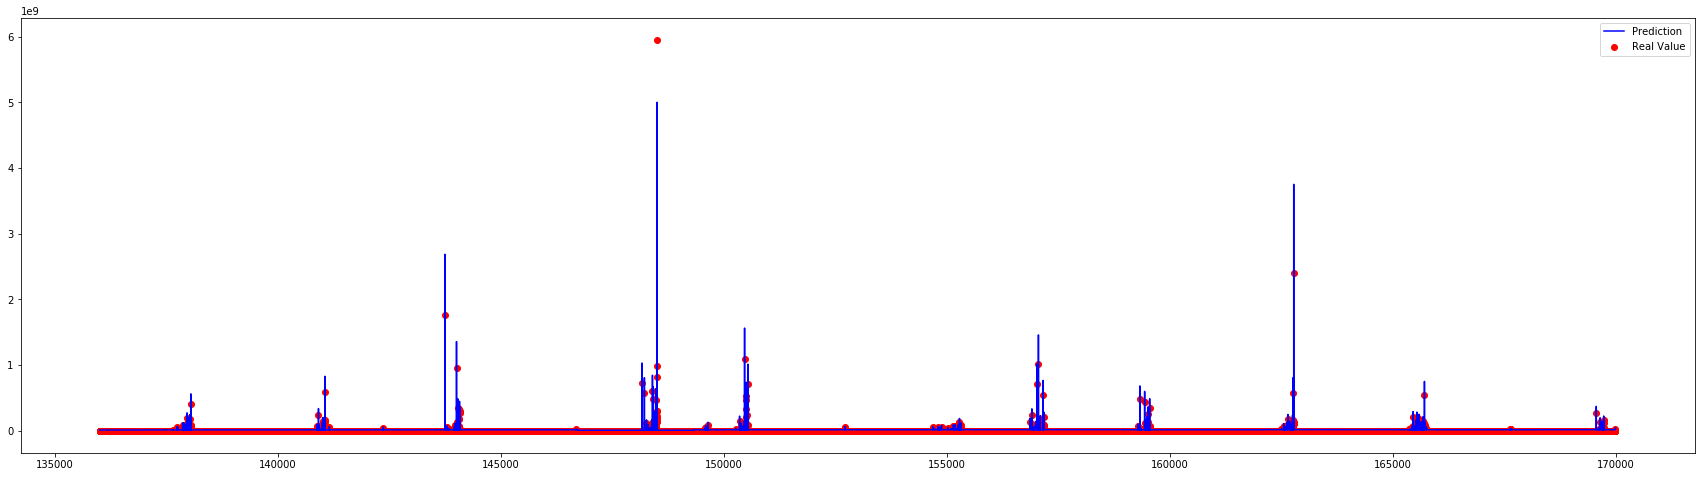

In [73]:
fig = plt.figure(figsize=(30,8))
ax = plt.axes()
idx = []
# for i in range(34000):
#     idx.append(i)
predictions
    
ax.plot(y_test.index, predictions, color = 'blue', label='Prediction')
ax.scatter(y_test.index, y_test, color = 'red', label='Real Value')

ax.legend(loc='best')
plt.show()